In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

# matplotlib inline

In [5]:
# train_set_x_orig ：保存的是训练集里面的图像数据（本训练集有209张64x64的图像）。
# train_set_y_orig ：保存的是训练集的图像对应的分类值（【0 | 1】，0表示不是猫，1表示是猫）。
# test_set_x_orig ：保存的是测试集里面的图像数据（本训练集有50张64x64的图像）。
# test_set_y_orig ： 保存的是测试集的图像对应的分类值（【0 | 1】，0表示不是猫，1表示是猫）。
# classes ： 保存的是以bytes类型保存的两个字符串数据，数据为：[b’non-cat’ b’cat’]。
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


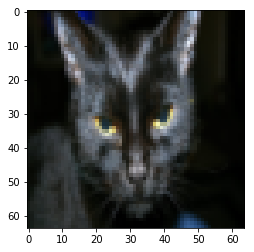

In [6]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [7]:
m_train = train_set_x_orig.shape [0]  # m_train（训练集示例数量）
num_px = train_set_x_orig.shape [1]  # num_px（=训练图像的高度=训练图像的宽度）
m_test = test_set_x_orig.shape [0]      # m_test（测试集示例数量）

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [8]:
#为了方便起见,重塑维度, 此后，我们的训练（和测试）数据集是一个numpy数组，其中每列代表一个展平的图像。 应该有m_train（和m_test）列。

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T

test_set_x_flatten = test_set_x_orig.reshape(-1,test_set_x_orig.shape[0])

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


机器学习中一个常见的预处理步骤是对数据集进行居中和标准化，这意味着你要从每个示例中减去整个numpy数组的均值，然后除以整个numpy数组的标准差。但是图片数据集则更为简单方便，并且只要将数据集的每一行除以255（像素通道的最大值），效果也差不多。

In [9]:
# “标准化”数据

train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.


你需要记住的内容：

预处理数据集的常见步骤是：

     找出数据的尺寸和维度（m_train，m_test，num_px等）
     重塑数据集，以使每个示例都是大小为（num_px \ num_px \ 3，1）的向量
     “标准化”数据

关键步骤： 在本练习中，你将执行以下步骤：

     初始化模型参数
     通过最小化损失来学习模型的参数
     使用学习到的参数进行预测（在测试集上）
     分析结果并得出结论

建立神经网络的主要步骤是： 1.定义模型结构（例如输入特征的数量） 2.初始化模型的参数 3.循环：

     计算当前损失（正向传播）
     计算当前梯度（向后传播）
     更新参数（梯度下降）

In [10]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    s = 1/(1 + np.exp(-z))
    return s

In [11]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


In [12]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    w = np.zeros((dim,1))  # 对于图像输入，w的维度为(num_px  num_px  3, 1)。
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b,float) or isinstance(b,int))

    return w, b

In [13]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


In [14]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T,X) + b) 
    #########error np.dot(Y,np.log(A))
    cost = -1 * np.mean(Y * np.log(A) + (1 - Y) * np.log(1 - A))

    dw = 1 / m * np.dot(X,(A - Y).T)
    db = np.mean(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [15]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


优化函数:

        初始化参数。
        计算损失函数及其梯度。
        使用梯度下降来更新参数。

In [16]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

    costs = [] 

    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]   # grads 是字典
        db = grads["db"]

        w = w - learning_rate*dw
        b = b - learning_rate*db

        if i%100 == 0:
            costs.append(cost)
        if print_cost and i%100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs


In [17]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print(costs)

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828
[6.000064773192205]


In [18]:
# GRADED FUNCTION: predict

def predict(w, b, X):

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)

    A = sigmoid(np.dot(w.T,X) + b)
    for i in range(A.shape[1]):
        if A[0,i] < 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
    
    assert(Y_prediction.shape == (1,m))

    return Y_prediction
    

In [19]:
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1.]]


你需要记住以下几点： 你已经实现了以下几个函数：

    初始化（w，b）initialize_with_zeros(w,b)
    迭代优化损失以学习参数（w，b）：

        optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)
        计算损失及其梯度
        使用梯度下降更新参数
    使用学到的（w，b）来预测给定示例集的标签 predict(w, b, X)

In [20]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    w,b = initialize_with_zeros(X_train.shape[0])

    params, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)

    w = params["w"]
    b = params["b"]

    dw = grads["dw"]
    db = grads["db"]

    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d




In [21]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 66.0 %


y = 1, you predicted that it is a "cat" picture.


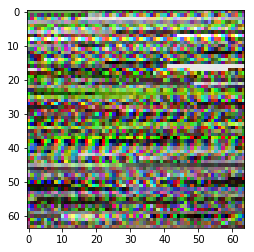

In [22]:
# Example of a picture that was wrongly classified.
index = 25
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

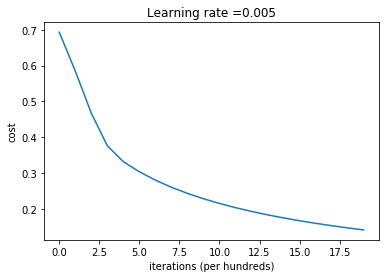

In [23]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [25]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 66.0 %

-------------------------------------------------------

learning rate is: 0.001


KeyboardInterrupt: 

In [ ]:
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
#my_image = "cat_in_iran.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = '/home/kesci/input/deeplearningai17761/cat_in_iran.jpg'
image = np.array(plt.imread(fname))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")